# Train an image classifier

In this tutorial, you will learn how to use PAX to train a simple Convolutional Neural Network (CNN) to classify hand-written digits from the MNIST dataset.

The outline of the tutorial:

1. MNIST dataset with `tensorflow_datasets`.
2. A simple CNN model.
3. Loss function and update function.
4. Data loader and training.

## MNIST dataset

First, we will load the MNIST dataset using `tensorflow_datasets` library and show a few examples.

In [1]:
# uncomment the following line to install pax
# !pip install -q git+https://github.com/NTT123/pax.git

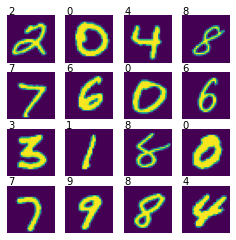

In [2]:
import math
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

mnist_data = tfds.load("mnist")


def plot_image_grid(images, labels):
    N = len(images)
    size = int(math.sqrt(N))
    plt.figure(figsize=(size, size))
    for i in range(N):
        plt.subplot(size, size, i + 1)
        plt.imshow(images[i, ..., 0])
        plt.text(0, -1, labels[i])
        plt.axis("off")
    plt.show()


batch = next(mnist_data["test"].take(16).batch(16).as_numpy_iterator())
plot_image_grid(batch["image"], batch["label"])

## Convolutional Neural Network

Now, we will use `PAX` to implement a simple CNN using the `pax.nn.Sequential`, `pax.nn.Conv2D` modules.


**Note**:

1.  `pax.nn.Sequential` allows us to define a module as a sequence of computational steps.
2.  `pax.nn.Conv2D` is the PAX's convolutional module for 2d images.
3.  `net.summary()` returns a summary of all submodules in `net` in a tree-like format.

In [3]:
import pax
import jax
import jax.numpy as jnp

pax.seed_rng_key(42)

net = pax.nn.Sequential(
    pax.nn.Conv2D(1, 32, 5, stride=1, padding="VALID"),
    jax.nn.relu,
    pax.nn.Conv2D(32, 64, 5, stride=2, padding="VALID"),
    jax.nn.relu,
    pax.nn.Conv2D(64, 128, 3, stride=2, padding="VALID"),
    jax.nn.relu,
    pax.nn.Conv2D(128, 10, 4, stride=1, padding="VALID"),
    lambda x: x.reshape((x.shape[0], -1)),
)

print(net.summary())

Sequential
├── Conv2D[in_features=1, out_features=32, kernel_shape=(5, 5), padding=VALID, with_bias=True, data_format=NHWC]
├── x => relu(x)
├── Conv2D[in_features=32, out_features=64, kernel_shape=(5, 5), padding=VALID, stride=(2, 2), with_bias=True, data_format=NHWC]
├── x => relu(x)
├── Conv2D[in_features=64, out_features=128, kernel_shape=(3, 3), padding=VALID, stride=(2, 2), with_bias=True, data_format=NHWC]
├── x => relu(x)
├── Conv2D[in_features=128, out_features=10, kernel_shape=(4, 4), padding=VALID, with_bias=True, data_format=NHWC]
└── x => <function <lambda> at 0x7fbff03e94c0>(x)


We plot the predictions of the untrained model as a simple sanity check.

**Note**: we are normalizing MNIST images to a value range of ``[-1, 1]`` which is the preferred range of neural nets.

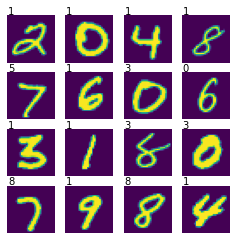

In [4]:
images = batch["image"].astype(jnp.float32) / 255.0 * 2.0 - 1.0
logits = net(images)
labels = jnp.argmax(logits, axis=-1)

plot_image_grid(images, labels)

## Loss function and update function

We will use a *cross-entropy* loss function.

In [5]:
def loss_fn(model: pax.Module, inputs):
    images, labels = inputs["image"], inputs["label"]
    images = images.astype(jnp.float32) / 255.0 * 2.0 - 1.0  # normalize to [-1, 1]
    model, logits = pax.module_and_value(model)(images)

    # cross entropy loss
    log_prs = jax.nn.log_softmax(logits)
    log_prs = jax.nn.one_hot(labels, num_classes=logits.shape[-1]) * log_prs
    log_pr = jnp.sum(log_prs, axis=-1)
    loss = -jnp.mean(log_pr)  # negative log likelihood
    return loss, (loss, model)

Next, we will implement an update function. It uses our model, optimizer, and data. It returns the updated model and updated optimizer. We use ``jax.jit`` to make the update function fast.

**Note**: 

1. PAX provides the same functionality in ``jax.utils.build_update_fn``.
2. `pax.grad_parameters` is a thin wrapper of `jax.grad`. It computes the gradients with respect to trainable parameters of a module.

In [6]:
import opax

# update_fn = jax.utils.build_update_fn(loss_fn)
def update_fn(model: pax.Module, optimizer: opax.GradientTransformation, inputs):
    grads, (loss, model) = pax.grad_parameters(loss_fn, has_aux=True)(model, inputs)
    model, optimizer = opax.apply_gradients(model, optimizer, grads=grads)
    return model, optimizer, loss


fast_update_fn = jax.jit(update_fn)

We use the ``adam`` optimizer from ``opax`` library.

In [7]:
learning_rate = 1e-4
optimizer = opax.adam(learning_rate)(net.parameters())

## Data loader and model training

Now, define a TensorFlow data loader:

In [8]:
batch_size = 128
num_training_steps = 1000

dataloader = (
    mnist_data["train"]
    .cache()
    .repeat()
    .shuffle(100 * batch_size)
    .batch(batch_size)
    .take(num_training_steps)
    .prefetch(1)
    .enumerate(1)
    .as_numpy_iterator()
)

Finally, let's train our model

[step 100]  loss 1.205
[step 200]  loss 0.373
[step 300]  loss 0.279
[step 400]  loss 0.203
[step 500]  loss 0.175
[step 600]  loss 0.153
[step 700]  loss 0.131
[step 800]  loss 0.129
[step 900]  loss 0.115
[step 1000]  loss 0.113


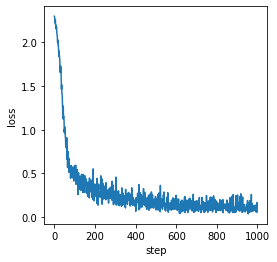

In [9]:
total_losses = 0.0
losses = []
for step, inputs in dataloader:
    net, optimizer, loss = fast_update_fn(net, optimizer, inputs)
    total_losses = loss + total_losses
    losses.append(loss)
    if step % 100 == 0:
        loss = total_losses / 100
        total_losses = 0.0
        print(f"[step {step}]  loss {loss:.3f}")

plt.figure(figsize=(4, 4))
plt.plot(losses)
plt.xlabel("step")
plt.ylabel("loss")
plt.show()

Let's plot the predictions of our trained model as a simple sanity check.

**Note**: we are doing prediction on the ``test`` set.

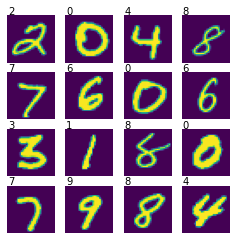

In [10]:
batch = next(mnist_data["test"].take(16).batch(16).as_numpy_iterator())
images = batch["image"].astype(jnp.float32) / 255.0 * 2.0 - 1.0  # [-1, 1]
logits = net(images)
labels = jnp.argmax(logits, axis=-1)

plot_image_grid(images, labels)